# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
#from pycaret.classification import *

In [2]:
songs = pd.read_csv('https://raw.githubusercontent.com/MerleSt/SpotifyPlaylistMoosic/main/Data/song_fatures_cleaned.csv', index_col=[0,1])

In [3]:
songs.shape

(5114, 13)

# Columns to keep /drop from Scientific Literature and General Understanding


Certainly! Let's go through each of the features:

__Danceability__:

Recommendation: Keep.
Reason: Represents how suitable a track is for dancing based on various musical elements including tempo, rhythm stability, beat strength, and overall regularity.
Reference:
Jehan, T. (2005). Creating music by listening. PhD thesis, Massachusetts Institute of Technology.

__Energy__:

Recommendation: Keep.
Reason: Measures intensity and activity, typically energetic tracks feel fast and noisy.
Reference:
Tzanetakis, G., & Cook, P. (2002). Musical genre classification of audio signals. IEEE Transactions on speech and audio processing, 10(5), 293-302.

Key:

Recommendation: Depends.
Reason: While the key is fundamental in music theory, its efficacy in clustering tasks can be dataset dependent. However, it might be important when distinguishing between certain types of genres or moods.
Reference:
Mardirossian, G., & Chew, E. (2015). Key-independent multi-level tonal analysis for interactive music systems. In Proceedings of the ACM SIGCHI Conference on Human Factors in Computing Systems.

__Loudness__:

Recommendation: Keep but be cautious of its correlation with 'Energy'.
Reason: The perceived volume of the song can distinguish between certain moods or genres.
Reference:
Vickers, E. (2011). The loudness war: Background, speculation and recommendations. Audio Engineering Society Convention 131.

__Mode__:

Recommendation: Keep.
Reason: Major or minor mode can influence the mood or feel of a song.
Reference:
Huron, D. (2008). Sweet Anticipation: Music and the Psychology of Expectation. MIT Press.

__Speechiness__:

Recommendation: Keep.
Reason: Differentiates between talk shows, podcasts, and music.
Reference:
Mesaros, A., Heittola, T., Benetos, E., Foster, P., Lagrange, M., Virtanen, T., & Dixon, S. (2018). Detection and Classification of Acoustic Scenes and Events: Outcome of the DCASE 2016 Challenge. IEEE/ACM Transactions on Audio, Speech, and Language Processing.

__Acousticness__:

Recommendation: Keep.
Reason: Helps distinguish between electronic and acoustic music.
Reference:
Sturm, B. L., Diver, C., & Martinez, A. R. (2013). An evaluation of the audio feature space for detecting fake musical instrument samples.
In Proceedings of the Sound and Music Computing Conference.

__Instrumentalness__:

Recommendation: Keep.
Reason: Determines the presence of vocals in a song, distinguishing between purely instrumental tracks and those with lyrics.
Reference:
Leglaive, S., Hennequin, R., & Badeau, R. (2015). Singing voice detection with deep recurrent neural networks. In IEEE International Conference on Acoustics, Speech and Signal Processing.

__Liveness__:

Recommendation: Keep.
Reason: Identifies the presence of a live audience, differentiating studio recordings from live performances.
Reference:
Dittmar, C., & Müller, M. (2012). Automatic annotation of recorded music. In Multimodal Music Processing (Vol. 3).

__Valence__:

Recommendation: Keep.
Reason: Measures the musical positiveness of a track, can differentiate between moods.
Reference:
Yang, Y. H., & Chen, H. H. (2012). Machine recognition of music emotion: A review. ACM Transactions on Intelligent Systems and Technology (TIST), 3(3).

__Tempo__:

Recommendation: Keep.
Reason: The speed of a track is one of the fundamental aspects of music.
Reference:
Dixon, S. (2001). Automatic extraction of tempo and beat from expressive performances. Journal of New Music Research, 30(1), 39-58.

Duration_ms:

Recommendation: Consider.
Reason: The length of a track might not inherently convey much about its musical content, but it could be relevant depending on the dataset.
Reference:
Not commonly discussed in literature for its inherent musical properties.

Time_signature:

Recommendation: Depends.
Reason: Time signature can be critical for certain genres or analyzing complex rhythmic structures but might be less informative for general clustering tasks.
Reference:
Gouyon, F., Klapuri, A., Dixon, S., Alonso, M., Tzanetakis, G., Uhle, C., & Cano, P. (2006). An experimental comparison of audio tempo induction algorithms. IEEE Transactions on Audio, Speech, and Language Processing, 14(5), 1832-1844.

__DROP__
> time_signature, Duration_ms, Key

In [4]:
songs.drop(columns=['time_signature', 'duration_ms', 'key'], inplace = True)

# Scale

Since we found a few outliers in the data preprocessing operation, we need to either use a scalar, which corrects for this, drop the data, or use a model with weights. A combination of all of those is possible as well. 
1. Dropping all data is not an ideal solution, since there are too many outliers
2. A scalar to use here could be the RObust Scaler which corrects for outliers
3. Weights can be attricuted according to the distance to the centroid, hence, points further away have a lower weight in the clustering. This can be implemented in the K-means model. Since we will evaluate the model later on, we should not just decide on one strategy yet, but implement multiple and compare the results.

## Robust Scaler

In [20]:
# Define the scaler, use it and then transform the data into a dataframe again
scaler = RobustScaler()
songs_scaled = scaler.fit_transform(songs)
songs_robust = pd.DataFrame(songs_scaled, columns=songs.columns, index=songs.index)

In [21]:
songs_robust.shape

(5114, 10)

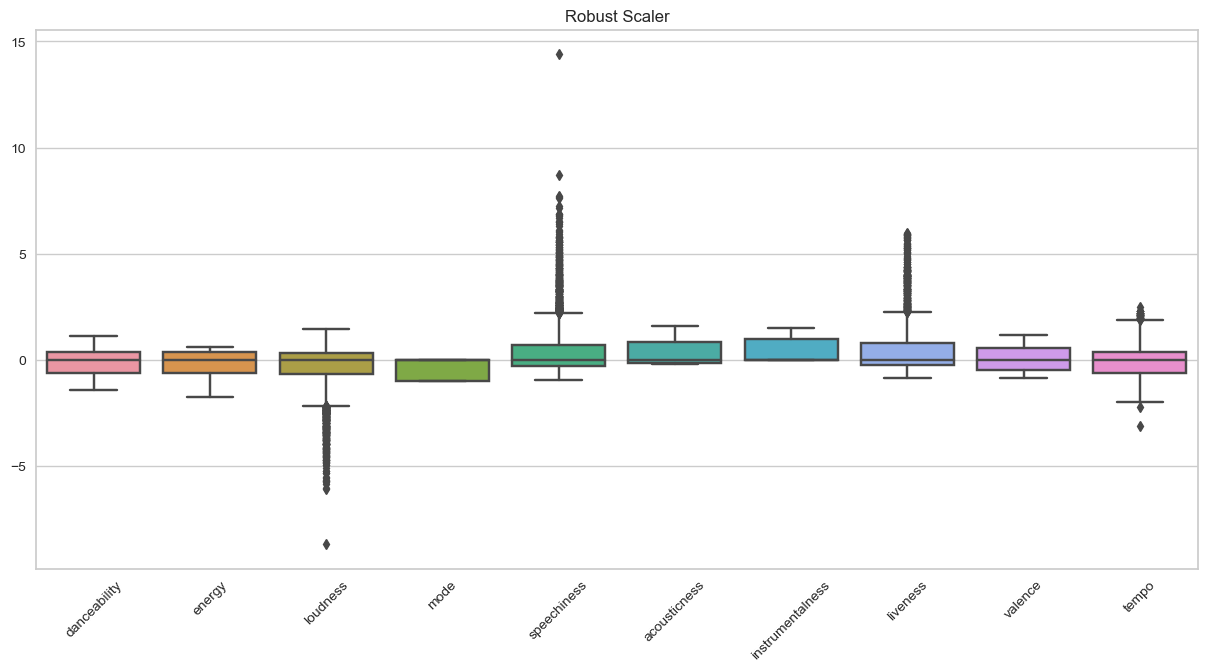

In [22]:
# Let us look at the outliers again
plt.figure(figsize=(15, 7))
sns.boxplot(data=songs_robust)
plt.title('Robust Scaler')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.show()

## MinMax Scaler

In [23]:
scaler = MinMaxScaler()
songs_scaled = scaler.fit_transform(songs)
songs_minmax = pd.DataFrame(songs_scaled, columns=songs.columns, index=songs.index)

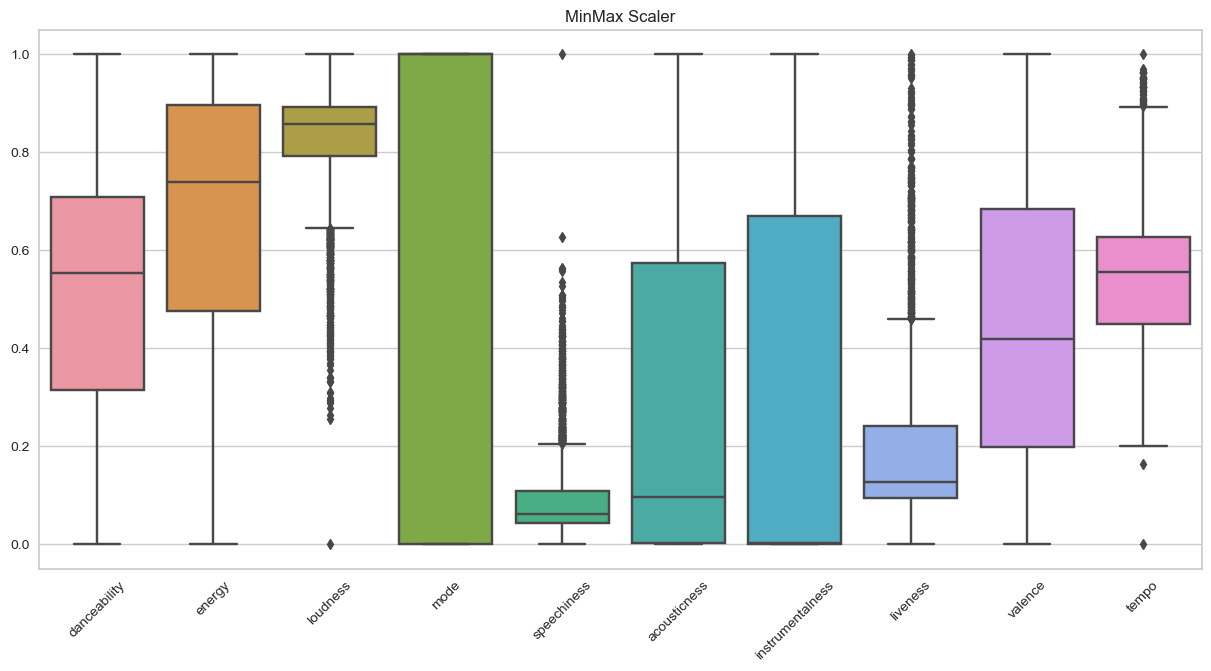

In [24]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=songs_minmax)
plt.title('MinMax Scaler')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.show()

# Determine Number of Ks

In [25]:
# # Instantiate the clustering model and visualizer
# model = KMeans(n_init=10, random_state=213)
# visualizer = KElbowVisualizer(model, k=(20,100))

# visualizer.fit(songs_robust)        # Fit the data to the visualizer
# visualizer.show();

In [26]:
# k_robust = visualizer.elbow_value_
# print(f"The optimal number of clusters with a robust scaler is: {k_robust}")

In [27]:
k_robust = 51
k_minmax = 55

In [28]:
# # Instantiate the clustering model and visualizer
# model = KMeans(n_init=10, random_state=213)
# visualizer = KElbowVisualizer(model, k=(20,100))

# visualizer.fit(songs_minmax)        # Fit the data to the visualizer
# visualizer.show();

In [29]:
# k_minmax = visualizer.elbow_value_
# print(f"The optimal number of clusters with the minmax scaler is: {k_minmax}")

# K-Means

Let's say you would prefer the MinMax Scaler since it makes readability and explanations easier, but you do not want to drop all outliers. Another idea would be to implement weights to the oberservations. The further an pbservation from their cluster, the lower their weight. 

In [30]:
# Step 1: Initial K-means run
kmeans = KMeans(n_init=10, n_clusters=k_minmax, random_state=213) # adjust the number of clusters as needed
kmeans.fit(songs_minmax)
initial_centroids = kmeans.cluster_centers_

# Step 2: Compute distance of each sample to its closest centroid
songs_array = songs_robust.to_numpy()  # Convert DataFrame to numpy array
n_samples = songs_array.shape[0]

# Using broadcasting to compute distances
expanded_songs = songs_array[:, np.newaxis, :]
expanded_centroids = initial_centroids[np.newaxis, :, :]
distances_all = np.linalg.norm(expanded_songs - expanded_centroids, axis=2)
distances = np.min(distances_all, axis=1)

# Step 3: Assign weights inversely proportional to distances 
weights = 1.0 / (distances + 1e-10)

# Now, you can use these weights in K-means
kmeans_weighted = KMeans(n_init=10, n_clusters=k_minmax, random_state=213)
clusters = kmeans_weighted.fit_predict(songs_robust, sample_weight=weights)

songs_minmax['cluster'] = clusters

In [31]:
songs_minmax

,,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
name,artist,,,,,,,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.680455,0.25900,0.763897,0.0,0.076797,0.696787,0.000060,0.987842,0.310660,0.515800,31
Saudade De Bahia,Antônio Carlos Jobim,0.767322,0.39900,0.771967,1.0,0.037691,0.217871,0.000002,0.108409,0.703553,0.584322,18
"Canta Canta, Minha Gente",Martinho Da Vila,0.880041,0.73000,0.798018,1.0,0.377996,0.454819,0.000064,0.125633,0.918782,0.437862,54
Mulher Eu Sei,Chico César,0.729059,0.05020,0.682811,1.0,0.051307,0.882530,0.000041,0.391084,0.531980,0.499098,43
Rosa Morena,Kurt Elling,0.673216,0.11900,0.655228,1.0,0.041394,0.919679,0.000348,0.105370,0.408122,0.565171,30
...,...,...,...,...,...,...,...,...,...,...,...,...
"1812 Festival Overture, Op. 49: 1812 Overture, Op. 49",Pyotr Ilyich Tchaikovsky,0.208893,0.06940,0.596818,1.0,0.051525,0.920683,0.725888,0.084296,0.066497,0.410795,40
"Winter Fragments pour ensemble instrumental, sons de synthèse et dispositif électronique",Tristan Murail,0.194416,0.10100,0.621548,1.0,0.048148,0.858434,0.432487,0.070314,0.036041,0.388495,40
"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3 Farben (Colours)",Arnold Schoenberg,0.061634,0.00093,0.277803,1.0,0.047277,0.954819,0.983756,0.078217,0.034924,0.334469,3


## Normal K-Means

### Robust Scaler

In [32]:
kmeans = KMeans(n_init=10, n_clusters=k_robust, random_state=213)  # random_state for reproducibility
songs_robust['cluster'] = kmeans.fit_predict(songs_robust)

### MinMax Scaler

In [33]:
kmeans = KMeans(n_init=10, n_clusters=k_minmax, random_state=213)  # random_state for reproducibility
songs_minmax['cluster'] = kmeans.fit_predict(songs_minmax)

In [34]:
from sklearn_extra.cluster import KMedoids

# Assuming you have your data in a DataFrame called songs_robust, without the cluster column
data = songs_robust.drop(columns='cluster', errors='ignore')


# Initialize and fit the model
kmedoids = KMedoids(n_clusters=k, metric='euclidean', init='heuristic', random_state=213)
songs_robust['cluster'] = kmedoids.fit_predict(data)

NameError: name 'k' is not defined

In [ ]:
# Step 1: Merge the dataframes
merged_df = songs_robust[['cluster']].merge(songs_minmax[['cluster']], left_index=True, right_index=True, suffixes=('_robust', '_minmax'))

# Step 2: Create a contingency table
contingency_table = pd.crosstab(merged_df['cluster_robust'], merged_df['cluster_minmax'])

# Display the table
print(contingency_table)

Let me use the songs_robust clusters from the Robust K-Means with the Robust Scaler from here on.

Let us look at the correlation between features, as to decide whether we can drop columns and refine our model.

In [ ]:
# Assuming songs_robust is your DataFrame
correlation_matrix = songs_robust[songs_robust.columns].corr()

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Feature Importance

## Extra Trees Classifier

### Robust

In [35]:
# Tree model classifiers
songs_without_cluster = songs_robust.drop('cluster', axis=1)
tree_model = ExtraTreesClassifier().fit(songs_without_cluster, clusters)
feature_importance = tree_model.feature_importances_

ranked_features = [x for _, x in sorted(zip(feature_importance, songs_without_cluster.columns), reverse=True)]
print("Ranked Features:", ranked_features)

Ranked Features: ['tempo', 'liveness', 'speechiness', 'loudness', 'energy', 'valence', 'acousticness', 'instrumentalness', 'danceability', 'mode']


In [36]:
features_with_importance = sorted(list(zip(songs_without_cluster.columns, feature_importance)), key=lambda x: x[1], reverse=True)

for feature, importance in features_with_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: tempo, Importance: 0.15068530816574116
Feature: liveness, Importance: 0.1361427718770235
Feature: speechiness, Importance: 0.13134472555698656
Feature: loudness, Importance: 0.11128352062771688
Feature: energy, Importance: 0.09158780362903425
Feature: valence, Importance: 0.09154511025648177
Feature: acousticness, Importance: 0.085120967560098
Feature: instrumentalness, Importance: 0.08346566757569147
Feature: danceability, Importance: 0.08230868822344985
Feature: mode, Importance: 0.03651543652777673


### MinMax

In [37]:
# Tree model classifiers
songs_without_cluster = songs_minmax.drop('cluster', axis=1)
tree_model = ExtraTreesClassifier().fit(songs_without_cluster, clusters)
feature_importance = tree_model.feature_importances_

ranked_features = [x for _, x in sorted(zip(feature_importance, songs_without_cluster.columns), reverse=True)]
print("Ranked Features:", ranked_features)

Ranked Features: ['tempo', 'liveness', 'speechiness', 'loudness', 'valence', 'energy', 'acousticness', 'instrumentalness', 'danceability', 'mode']


In [38]:
features_with_importance = sorted(list(zip(songs_without_cluster.columns, feature_importance)), key=lambda x: x[1], reverse=True)

for feature, importance in features_with_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: tempo, Importance: 0.1540201154779712
Feature: liveness, Importance: 0.13639500321585651
Feature: speechiness, Importance: 0.1318216470558104
Feature: loudness, Importance: 0.1108788923403626
Feature: valence, Importance: 0.09187146081491239
Feature: energy, Importance: 0.09069119444368383
Feature: acousticness, Importance: 0.08387515277070995
Feature: instrumentalness, Importance: 0.08281679928519192
Feature: danceability, Importance: 0.08157675972696449
Feature: mode, Importance: 0.03605297486853677


## Correlation Matrix of Features

Let us look at the correlation between features, as to decide whether we can drop columns and refine our model.

In [39]:
# Assuming songs_robust is your DataFrame
songs_cluster = songs_minmax.drop('cluster', axis=1)
correlation_matrix = songs_cluster[songs_cluster.columns].corr()
correlation_matrix

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
danceability,1.000000,0.038752,0.355277,-0.083810,0.037199,-0.107204,-0.572295,-0.027832,0.680607,-0.008977
energy,0.038752,1.000000,0.787901,-0.010320,0.309862,-0.852631,-0.168540,0.172103,0.156522,0.211375
loudness,0.355277,0.787901,1.000000,-0.029369,0.238916,-0.697149,-0.468724,0.138220,0.334090,0.211888
mode,-0.083810,-0.010320,-0.029369,1.000000,-0.042403,0.029395,-0.006184,-0.011277,0.007838,0.003077
speechiness,0.037199,0.309862,0.238916,-0.042403,1.000000,-0.270257,-0.063959,0.085533,-0.012156,0.060589
acousticness,-0.107204,-0.852631,-0.697149,0.029395,-0.270257,1.000000,0.191980,-0.104940,-0.129302,-0.187175
instrumentalness,-0.572295,-0.168540,-0.468724,-0.006184,-0.063959,0.191980,1.000000,-0.054768,-0.500920,-0.069002
liveness,-0.027832,0.172103,0.138220,-0.011277,0.085533,-0.104940,-0.054768,1.000000,0.011380,0.036759
valence,0.680607,0.156522,0.334090,0.007838,-0.012156,-0.129302,-0.500920,0.011380,1.000000,0.101288
tempo,-0.008977,0.211375,0.211888,0.003077,0.060589,-0.187175,-0.069002,0.036759,0.101288,1.000000


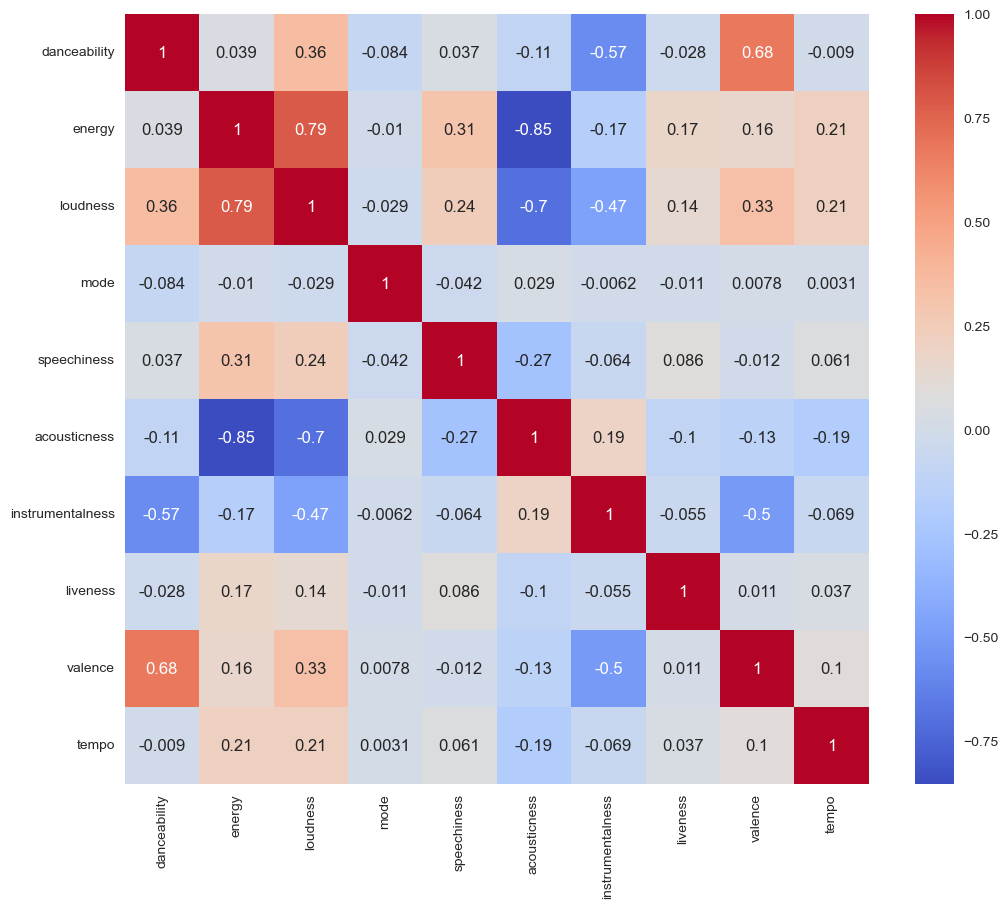

In [40]:
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Evaluating the Model

## Silhouette Score

Definition: The Silhouette Score measures how close each point in one cluster is to the points in the neighboring clusters.

Silhouette Score:
Range: The silhouette score ranges from -1 to 1.

Interpretation:

- Near +1: The clusters are well apart from each other and clearly distinguished.
- 0: The clusters are overlapping and there is considerable intermingling.
- Near -1: Points have been assigned to the wrong clusters.

General Guideline:

over 0.7: A strong structure has been found.

0.5 - 0.7: A reasonable structure has been found.

0.25 - 0.5: The structure is weak and could be artificial. Try additional cluster evaluation metrics and techniques.

< 0.25: No substantial structure has been found.

In [41]:
# Assume kmeans is your clustering model and X is your data
score = silhouette_score(songs_robust, kmeans.labels_, random_state=213)
print("Silhouette Score: ", score)

Silhouette Score:  -0.2061338488185666


In [42]:
# Assume kmeans is your clustering model and X is your data
score = silhouette_score(songs_minmax, kmeans.labels_, random_state=213)
print("Silhouette Score: ", score)

Silhouette Score:  0.6118789314715375


## Davies-Bouldin Index

The Davies-Bouldin index signifies the average 'similarity' ratio of each cluster with its most similar cluster. Here, 'similarity' is a measure that compares the distance between clusters with the size of the clusters themselves.

Range: The DB index values start from 0 and can be infinite.

Interpretation:

- Lower values: Indicate better clustering. Ideally, you want the DB index to be as close to 0 as possible.
- Higher values: Indicate that the clusters are less dense and/or more separated.

General Guideline:

As with any heuristic, there's no strict threshold for a "good" DB index value because it largely depends on the dataset. Still, lower is better. If you try different clustering configurations or algorithms, you'd prefer the one with a lower DB index over others.

In [43]:
# Assume kmeans is your clustering model and X is your data
db_score = davies_bouldin_score(songs_robust, kmeans.labels_)
print("Davies-Bouldin Index: ", db_score)

Davies-Bouldin Index:  7.51415590039779


In [44]:
# Assume kmeans is your clustering model and X is your data
db_score = davies_bouldin_score(songs_minmax, kmeans.labels_)
print("Davies-Bouldin Index: ", db_score)

Davies-Bouldin Index:  0.6696295584034224


The best model so far is the Normal K-Means using the MinMax Scaler

# Improving the Model

## Principal Component Analysis

In [45]:
# Initialize PCA
pca = PCA()
songs_no_cluster = songs_minmax.drop('cluster', axis=1, errors='ignore') # errors='ignore' ensures no error if the column doesn't exist
# Fit and transform the data
songs_pca = pca.fit_transform(songs_no_cluster)

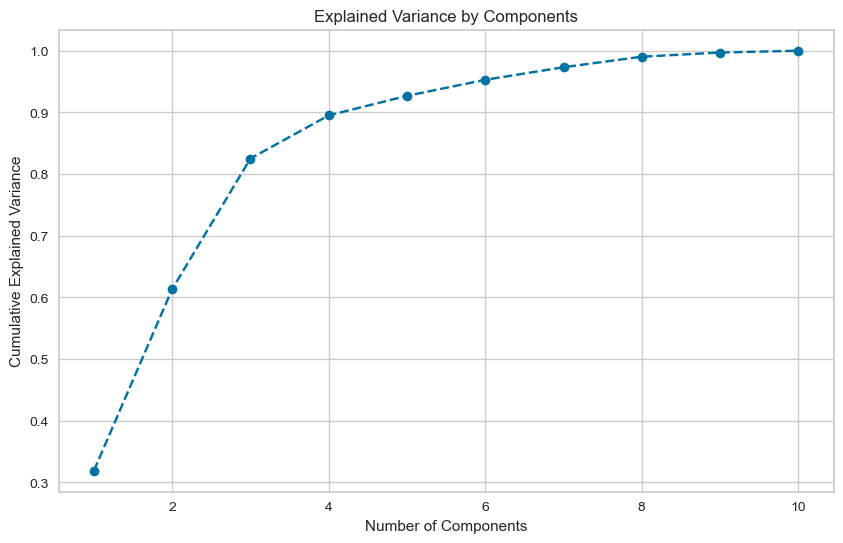

In [46]:
plt.figure(figsize=(10,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [47]:
pd.DataFrame(pca.components_, columns=songs_no_cluster.columns, index=[f'PC{i+1}' for i in range(len(pca.components_))])

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
PC1,-0.248396,-0.414496,-0.165074,0.277043,-0.036394,0.537350,0.519306,-0.037767,-0.314176,-0.051080
PC2,-0.037640,-0.115988,-0.043974,-0.959450,-0.003348,0.134252,0.180375,-0.007625,-0.108363,-0.016800
PC3,-0.318553,0.429874,0.053248,0.024235,0.037863,-0.534984,0.543646,0.034903,-0.352890,0.036982
PC4,0.320806,0.043672,-0.011350,0.016281,-0.017716,-0.007362,0.614621,-0.050254,0.716638,0.023650
PC5,-0.353835,0.266267,0.043895,-0.019355,0.018642,0.307385,-0.036187,0.786349,0.226870,0.188798
PC6,0.545763,-0.169473,-0.005098,0.031367,0.034143,-0.164322,0.108372,0.567711,-0.272731,-0.485615
PC7,0.340178,-0.268056,-0.003098,0.017390,0.006930,-0.148190,0.061879,0.161574,-0.207428,0.846843
PC8,-0.418799,-0.602461,-0.261519,-0.013289,-0.128015,-0.511968,-0.062276,0.166453,0.279336,-0.070481
PC9,-0.051532,-0.086456,-0.108276,0.003726,0.987059,-0.022750,-0.005845,-0.017804,0.054536,-0.002015
PC10,0.125156,0.293485,-0.941156,-0.000454,-0.068428,0.029891,-0.060667,-0.001575,-0.039592,0.040016


In [48]:
for i in range(1,11):
    pca = PCA(n_components=i, random_state=213)
    songs_pca = pca.fit_transform(songs_no_cluster)
    kmeans = KMeans(n_init=10, n_clusters=55, random_state=213)  # or the number of clusters you've determined

    # Fit the model and predict cluster labels
    clusters = kmeans.fit_predict(songs_pca)

    # Add to your dataframe
    songs_minmax['cluster'] = clusters
    silhouette_avg = silhouette_score(songs_pca, songs_minmax['cluster'], random_state=213)
    print(f"The average silhouette score for {i} number of components is:", silhouette_avg)

The average silhouette score for 1 number of components is: 0.5254842854662473
The average silhouette score for 2 number of components is: 0.45902197940613737
The average silhouette score for 3 number of components is: 0.36086620394197977
The average silhouette score for 4 number of components is: 0.31846863421798755
The average silhouette score for 5 number of components is: 0.251418033993133
The average silhouette score for 6 number of components is: 0.21295207715919168
The average silhouette score for 7 number of components is: 0.18189820266124418
The average silhouette score for 8 number of components is: 0.17599406083463032
The average silhouette score for 9 number of components is: 0.1626896520794253
The average silhouette score for 10 number of components is: 0.16507929979201277


Conclusion. PCA is not a great method. Let us move on.

## Feature Importance

In [49]:
#Assuming the cluster labels are stored in a 'cluster' column in your songs_minmax dataframe
target_variable = songs_minmax['cluster']

# Drop the 'cluster' column from songs_minmax before fitting the RandomForest
songs_minmax_without_clusters = songs_minmax.drop('cluster', axis=1)

rf = RandomForestRegressor(n_estimators=100)
rf.fit(songs_minmax_without_clusters, target_variable)

importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': songs_minmax_without_clusters.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


feature_importance_df

,Feature,Importance
6,instrumentalness,0.134285
8,valence,0.126743
0,danceability,0.124574
5,acousticness,0.117934
1,energy,0.111553
9,tempo,0.104275
7,liveness,0.100733
3,mode,0.098073
2,loudness,0.042833
4,speechiness,0.038998


Conclusion: Keep all features since their importance is above at least 1%. Maybe look at correlation.

## Dropping correlated ones

Impact on Distance-based Models: In K-means or hierarchical clustering, correlated features might lead to distorted distances and thus clusters.

In [133]:
songs_uncorrelated = songs_minmax.drop(columns=['mode','danceability', 'energy'])

In [134]:
kmeans = KMeans(n_init=10, n_clusters=k_minmax, random_state=213)  # random_state for reproducibility
songs_uncorrelated['cluster'] = kmeans.fit_predict(songs_uncorrelated)

In [135]:
# Assume kmeans is your clustering model and X is your data
score = silhouette_score(songs_uncorrelated, kmeans.labels_, random_state=213)
print("Silhouette Score: ", score)

Silhouette Score:  0.738157612297464


In [136]:
songs_uncorrelated.loc[songs_uncorrelated['cluster']==9].sample(10)

,,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
name,artist,,,,,,,,
Dissolved,Polluted Inheritance,0.792230,0.174292,0.000127,0.489340,0.053191,0.187817,0.700206,9
Ego Art,Altar,0.856297,0.108932,0.000090,0.411168,0.127660,0.251777,0.474527,9
Born Dead,Death,0.890890,0.173203,0.000002,0.304569,0.269504,0.066091,0.506678,9
Wolf Among Sheep,Broken Hope,0.823726,0.131808,0.166667,0.460914,0.509625,0.231472,0.485420,9
Under The Moon's Fog,Vital Remains,0.850217,0.157952,0.000345,0.406091,0.103343,0.034924,0.676424,9
Death to Death,Sacrificium,0.859183,0.051525,0.000086,0.385787,0.222898,0.260914,0.444596,9
The Lost Memories,Purtenance,0.869681,0.276688,0.004006,0.611168,0.191489,0.043959,0.578817,9
In Grief,God Macabre,0.878452,0.053050,0.000004,0.384772,0.083283,0.155330,0.416767,9
Hell Written,Edge Of Sanity,0.889651,0.117647,0.000019,0.403046,0.353597,0.270051,0.533422,9


#### Transforming Danceability

In [ ]:
songs_uncorrelated['danceability'] = np.log(songs_uncorrelated['danceability']+1)

In [ ]:
kmeans = KMeans(n_init=10, n_clusters=k_minmax, random_state=213)  # random_state for reproducibility
songs_uncorrelated['cluster'] = kmeans.fit_predict(songs_uncorrelated)
# Assume kmeans is your clustering model and X is your data
score = silhouette_score(songs_uncorrelated, kmeans.labels_, random_state=213)
print("Silhouette Score: ", score)

t-SNE, UMAP can be explored as models

In [ ]:
songs_minmax

Conclusion: The best model so far drops energy, danceability and uses the K-Means model while applying the MinMax Scaler.

## Other models

Alternatives to K-means
DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
Doesn't assume clusters to be of any particular shape.
Can find arbitrarily shaped clusters.
Identifies points that don't belong to any cluster, classifying them as noise.
Agglomerative Hierarchical Clustering
Builds a tree of clusters.
Useful if you want a hierarchy of clusters.
Gaussian Mixture Models (GMM)
Assumes that data is generated from a mixture of several Gaussian distributions.
Can model elliptical clusters.
Spectral Clustering
Can capture complex cluster structures.
Can identify clusters of non-convex shapes.

How to Test K-means Assumptions
Visual Inspection

The easiest way, if feasible, is to visualize the data in 2D or 3D.
If clusters seem non-spherical or have different sizes/densities, K-means might not be the best choice.
Silhouette Score

As you've already done, a silhouette score can indicate how well each point lies within its cluster.
A low average score might suggest the clusters aren't well-separated.
Check Cluster Sizes

After running K-means, if you find vastly different cluster sizes, it might suggest the equal size assumption is violated.
Comparing Algorithms

Run another clustering algorithm (like DBSCAN or GMM) and compare the results.
If you get significantly different clusters, it might suggest that K-means' assumptions aren't holding.

### DBSCAN

Basics of DBSCAN:
- Density: The number of points within a specified radius (eps).

- Core Point: A point that has at least a specified number (min_samples) of points within eps radius.

- Border Point: A point that has fewer than min_samples points within eps but is in the neighborhood of a core point.

- Noise Point: Neither a core nor a border point.

How DBSCAN Works:

- Start with an arbitrary point that has not been visited.
- Extract the neighborhood of this point using eps.
- If there are min_samples points within the eps neighborhood, start a new cluster. Otherwise, label the point as noise (which might later be detected as a border point).
- Continue the process with the next point.

Advantages:

- No Need to Specify Number of Clusters: Unlike K-means.
- Can Discover Clusters of Arbitrary Shapes: Unlike K-means, which is limited to convex and isotropic clusters.
- Robust to Outliers: It classifies them as noise.

In [ ]:
from sklearn.cluster import DBSCAN

songs_DBSCAN = songs_minmax.drop('cluster', axis=1)

# Create an instance of DBSCAN
db = DBSCAN(eps=0.4, min_samples=5)

# Fit the model
labels = db.fit_predict(songs_DBSCAN)

# The labels_ attribute contains the cluster labels (or -1 for noise points)
songs_DBSCAN['cluster'] = labels

In [ ]:
# Assume kmeans is your clustering model and X is your data
score = silhouette_score(songs_DBSCAN, kmeans.labels_, random_state=213)
print("Silhouette Score: ", score)

Conclusion: Playing around with the ps and min_samples does not improve the Silhouette Score, implying a model that does not fit the data well.

# Radarplot

# Export

In [ ]:
songs_minmax = songs_minmax.reset_index()

In [ ]:
songs_minmax.to_csv('/Users/merlesteffen/Documents/GitHub/Moosic/Data/playlists.csv', index=False)